# Import Libraries

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import timm
import numpy as np
import cv2
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sys, os
import math
import tensorflow as tf
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

/home2/roja26/miniconda3/envs/new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-02 23:36:08.952494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 23:36:12.026966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Model Code

In [2]:
import torch.nn as nn
import math
import torch
import torch.nn.functional as F
from torch.autograd import Variable

def make_model(args, parent=False):
    return RCAN(args)


class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False
        
class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)
        
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)
        
## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(RCAN, self).__init__()
        
        n_resgroups = args.n_resgroups
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        reduction = args.reduction 
        scale = args.scale[0]
        act = nn.ReLU(True)
        
        # RGB mean for DIV2K
        rgb_mean = (0.4488, 0.4371, 0.4040)
        rgb_std = (1.0, 1.0, 1.0)
        self.sub_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std)
        
        # define head module
        modules_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=args.res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, args.n_colors, kernel_size)]

        self.add_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std, 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x 

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))

# Training


In [3]:
def set_random_seed(seed_value):

    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    np.random.seed(seed_value)

# Set a specific seed value
seed_value = 83
set_random_seed(seed_value)

### Parallelization + Model Intialization

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")


Using 4 GPUs!


In [6]:
class Args:
    def __init__(self):
        self.n_resgroups = 10
        self.n_resblocks = 20
        self.n_feats = 64
        self.reduction = 16
        self.scale = [2]
        self.res_scale = 1
        self.n_colors = 3
        self.rgb_range = 1
args = Args()
rcan_model = make_model(args)
rcan_model = rcan_model
rcan_model = nn.DataParallel(rcan_model)
rcan_model = rcan_model.to(device)

In [52]:
epochs = 500
scale = 2
batchSize = 8

### Train, Val, Test Split

In [53]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import os

# Define the dataset root directory
dataset_root = 'trainsets/dataset_final/dataset'

# Define transformations for your images (e.g., resize, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Define paths for data and label folders
data_path = os.path.join(dataset_root, "64")
label_path = os.path.join(dataset_root, "128")

# Create ImageFolder instances for data and label folders
data_dataset = ImageFolder(root=data_path, transform=transform)
label_dataset = ImageFolder(root=label_path, transform=transform)

combined_dataset = []
for i in range(0, len(data_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))
# Define the ratio for train and test split
train_ratio = 0.8
val_ratio = 0.125

# Calculate the sizes of train and test sets
train_size = int(train_ratio * len(combined_dataset))
test_size = len(combined_dataset) - train_size


# Split the combined dataset into train and test sets
train_dataset, test_dataset = combined_dataset[:train_size], combined_dataset[train_size:]

val_size = int(val_ratio * len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [train_size - val_size, val_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# print size of train and test datasets
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))
print("Validation dataset size: ", len(val_dataset))

Train dataset size:  112
Test dataset size:  32
Validation dataset size:  16


### Landscape + Medical Data

In [54]:
# Define the dataset root directory
dataset_root = 'new_test/landscape_final'

# Define transformations for your images (e.g., resize, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Define paths for data and label folders
data_path = os.path.join(dataset_root, "64")
label_path = os.path.join(dataset_root, "128")

# Create ImageFolder instances for data and label folders
data_dataset = ImageFolder(root=data_path, transform=transform)
label_dataset = ImageFolder(root=label_path, transform=transform)

combined_dataset = []
for i in range(0, len(data_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))
    
landscape_test_loader = DataLoader(combined_dataset, batch_size=1, shuffle=False)

# Define the dataset root directory
dataset_root = 'new_test/medical_final'

# Define transformations for your images (e.g., resize, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Define paths for data and label folders
data_path = os.path.join(dataset_root, "64")
label_path = os.path.join(dataset_root, "128")

# Create ImageFolder instances for data and label folders
data_dataset = ImageFolder(root=data_path, transform=transform)
label_dataset = ImageFolder(root=label_path, transform=transform)

combined_dataset = []
for i in range(0, len(data_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))
    
medical_test_loader = DataLoader(combined_dataset, batch_size=1, shuffle=False)

### Other resolution test data

In [55]:
# Define the dataset root directory
dataset_root = 'trainsets/dataset_final/dataset'

# Define transformations for your images (e.g., resize, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Define paths for data and label folders
data_path = os.path.join(dataset_root, "32")
label_path = os.path.join(dataset_root, "64")

# Create ImageFolder instances for data and label folders
data_dataset = ImageFolder(root=data_path, transform=transform)
label_dataset = ImageFolder(root=label_path, transform=transform)

combined_dataset = []
for i in range(0, len(data_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))
    
test_32_loader = DataLoader(combined_dataset, batch_size=1, shuffle=False)

# Define the dataset root directory
dataset_root = 'trainsets/dataset_final/dataset'

# Define transformations for your images (e.g., resize, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Define paths for data and label folders
data_path = os.path.join(dataset_root, "128")
label_path = os.path.join(dataset_root, "256")

# Create ImageFolder instances for data and label folders
data_dataset = ImageFolder(root=data_path, transform=transform)
label_dataset = ImageFolder(root=label_path, transform=transform)

combined_dataset = []
for i in range(0, len(label_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))
    
test_128_loader = DataLoader(combined_dataset, batch_size=1, shuffle=False)

print(len(test_32_loader.dataset))
print(len(test_128_loader.dataset))

160
140


### View data

In [12]:
data, label = next(iter(train_loader))
print(f"Data shape: {data.shape}")
print(f"Label shape: {label.shape}")

Data shape: torch.Size([16, 3, 32, 32])
Label shape: torch.Size([16, 3, 64, 64])


torch.Size([64, 64, 3])


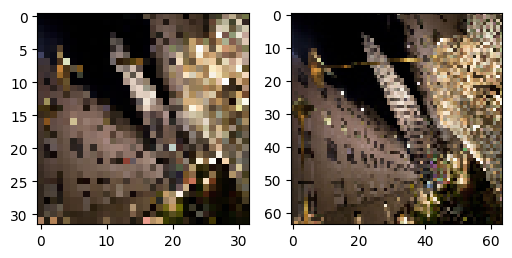

In [13]:
import matplotlib.pyplot as plt

# Display the first image in the batch
print(label[0].permute(1, 2, 0).shape)
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(data[0].permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(label[0].permute(1, 2, 0))
plt.show()


# PSNR + SSIM Code

In [56]:
from skimage.metrics import structural_similarity as ssim

def psnr_func(img1, img2):
    # Convert images to PyTorch tensors
    img1_tensor = torch.tensor(img1, dtype=torch.float32)
    img2_tensor = torch.tensor(img2, dtype=torch.float32)

    # Compute Mean Squared Error (MSE)
    mse = F.mse_loss(img1_tensor, img2_tensor)

    # Compute PSNR in decibels (dB)
    max_pixel_value = 1.0  # Assuming images are in the range [0, 255]
    psnr_db = 10 * torch.log10((max_pixel_value ** 2) / mse)

    return psnr_db.item()  # Return PSNR value in dB as a Python float

def ssim_func(img1, img2): # assuming both images are in range [0,1]
    img1 = (np.array(img1)*255).astype(np.uint8)
    img2 = (np.array(img2)*255).astype(np.uint8)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#     print(img1.dtype, img2.dtype)
    
    ssim_score = ssim(img1, img2)

    return ssim_score

# Train Loop

In [15]:
import torch.optim.lr_scheduler as lr_scheduler

ssim_arr = []
psnr_arr = []

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(rcan_model.parameters(), lr=0.001)

# Create ReduceLROnPlateau scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=10, verbose=True) ## reducring too much try factor =0.85 and patience = 10

# Training loop
for epoch in range(epochs):
    rcan_model.train()
    for i, (data, label) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)
        label = label.to(device)

        # Forward pass
        output = rcan_model(data)
        loss = criterion(output, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if ((epoch+1)%50 == 0 or epoch==0):
            print(f"Epoch: {epoch + 1}/{epochs}, Batch: {i + 1}/{len(train_loader)}, Loss: {loss.item():.6f}")

    if ((epoch+1)%1 == 0):
        rcan_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for j, (data, label) in enumerate(val_loader):
                data = data.to(device)
                label = label.to(device)
                output = rcan_model(data)
                loss = criterion(output, label)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            if ((epoch+1)%50 == 0 or epoch == 0):
                print(f"Validation Loss: {val_loss:.6f}")
                learning_rate = optimizer.param_groups[0]['lr']
                print("Learning rate:", learning_rate)
        
        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

# Save the trained rcan_model
torch.save(rcan_model.state_dict(), "trained_rcan_model_32_500_0.001_0.75_10.pth")


/home2/roja26/miniconda3/envs/new/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1/500, Batch: 1/7, Loss: 0.279481
Epoch: 1/500, Batch: 2/7, Loss: 4.567355
Epoch: 1/500, Batch: 3/7, Loss: 10.531096
Epoch: 1/500, Batch: 4/7, Loss: 9.082255
Epoch: 1/500, Batch: 5/7, Loss: 8.317331
Epoch: 1/500, Batch: 6/7, Loss: 1.082247
Epoch: 1/500, Batch: 7/7, Loss: 5.363153
Validation Loss: 1.161350
Learning rate: 0.001
Epoch: 50/500, Batch: 1/7, Loss: 0.107549
Epoch: 50/500, Batch: 2/7, Loss: 0.117761
Epoch: 50/500, Batch: 3/7, Loss: 0.095769
Epoch: 50/500, Batch: 4/7, Loss: 0.112700
Epoch: 50/500, Batch: 5/7, Loss: 0.103764
Epoch: 50/500, Batch: 6/7, Loss: 0.099264
Epoch: 50/500, Batch: 7/7, Loss: 0.108118
Validation Loss: 0.101936
Learning rate: 0.001
Epoch: 100/500, Batch: 1/7, Loss: 0.097751
Epoch: 100/500, Batch: 2/7, Loss: 0.108086
Epoch: 100/500, Batch: 3/7, Loss: 0.090256
Epoch: 100/500, Batch: 4/7, Loss: 0.086305
Epoch: 100/500, Batch: 5/7, Loss: 0.089308
Epoch: 100/500, Batch: 6/7, Loss: 0.116378
Epoch: 100/500, Batch: 7/7, Loss: 0.112211
Validation Loss: 0.0977

# Testing

### Load Pretrained Model

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [85]:
class Args:
    def __init__(self):
        self.n_resgroups = 10
        self.n_resblocks = 20
        self.n_feats = 64
        self.reduction = 16
        self.scale = [2]
        self.res_scale = 1
        self.n_colors = 3
        self.rgb_range = 1
args = Args()
rcan_model = make_model(args)
rcan_model = rcan_model
rcan_model = nn.DataParallel(rcan_model)

rcan_model.load_state_dict(torch.load("trained_rcan_model_64_100_0.001_0.75_10.pth"))

rcan_model = rcan_model.to(device)

In [53]:
print(count_parameters(rcan_model))

15444667


In [86]:
model = rcan_model.eval()

### Train Data Results

/tmp/ipykernel_1584/1785861820.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2_tensor = torch.tensor(img2, dtype=torch.float32)


PSNR Score:  18.99227523803711
SSIM Score:  0.6168370453839026


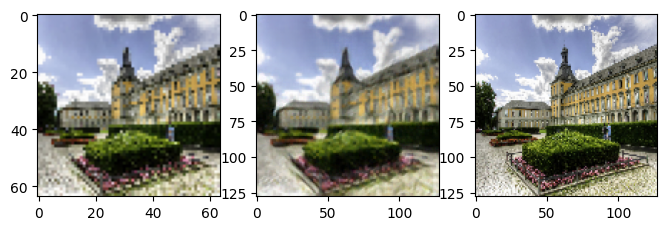

PSNR Score:  27.30453872680664
SSIM Score:  0.8851959036386177


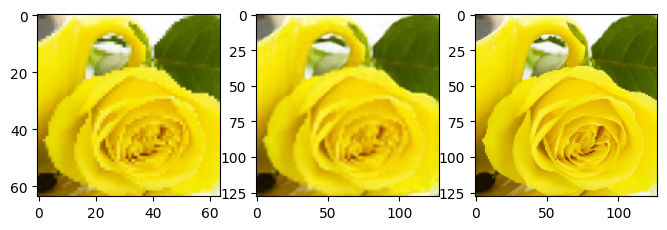

PSNR Score:  23.867979049682617
SSIM Score:  0.7469420370088352


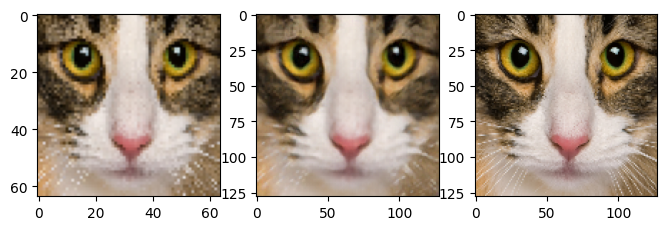

PSNR Score:  19.979646682739258
SSIM Score:  0.5820353456490452


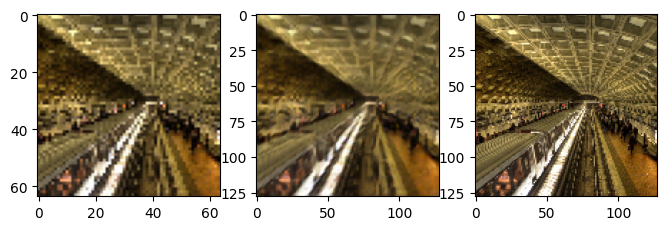

In [16]:
itr = 1
for img, label in train_loader:
    if itr == 5:
        break
    img = img.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = rcan_model(img)
    output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = (output * 255.0).round().astype(np.uint8)
    
    print("PSNR Score: ", psnr_func(output[0].transpose(1, 2, 0)/255, label[0].cpu().permute(1, 2, 0)))
    print("SSIM Score: ", ssim_func(output[0].transpose(1, 2, 0)/255, label[0].cpu().permute(1, 2, 0)))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0].cpu().permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(output[0].transpose(1, 2, 0))
    plt.subplot(1, 3, 3)
    plt.imshow(label[0].cpu().permute(1, 2, 0))
    plt.show()

    itr += 1

### Test Data Results

/tmp/ipykernel_1584/1785861820.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


psnr between model output and ideal output = 26.7611141204834
ssim between model output and ideal output = 0.8444830777873651


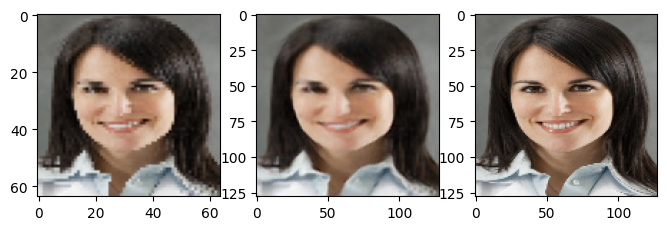

psnr between model output and ideal output = 20.63413429260254
ssim between model output and ideal output = 0.6482708470347418


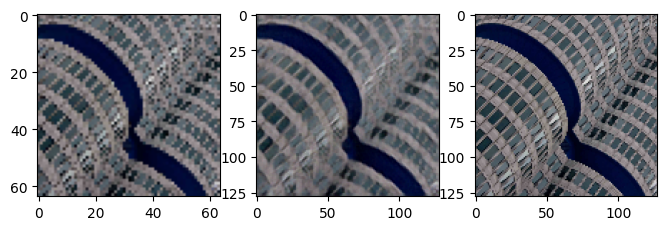

psnr between model output and ideal output = 19.430044174194336
ssim between model output and ideal output = 0.4383965293478082


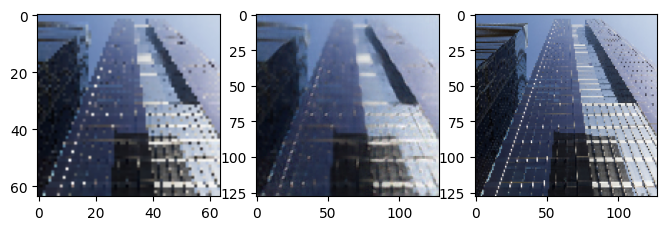

psnr between model output and ideal output = 23.575725555419922
ssim between model output and ideal output = 0.5357623766154724


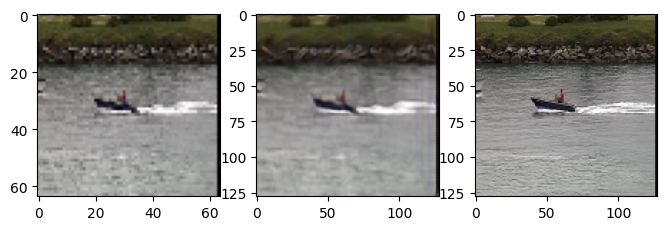

In [17]:
itr = 1
for img, label in test_loader:
    if itr == 5:
        break
    img = img.to(device)
    label = label.to(device)
    with torch.no_grad():
        output = rcan_model(img)
    output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = (output * 255.0).round().astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0].cpu().permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(output.transpose(1, 2, 0) / 255)
    plt.subplot(1, 3, 3)
    plt.imshow(label[0].cpu().permute(1, 2, 0))
    print(f"psnr between model output and ideal output = {psnr_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0) / 255)}")
    print(f"ssim between model output and ideal output = {ssim_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0) / 255)}")

    plt.show()
    itr += 1


### Medical + Landscape Data Results

/tmp/ipykernel_1584/1785861820.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


psnr between model output and ideal output = 28.843772888183594
ssim between model output and ideal output = 0.8713544751194572


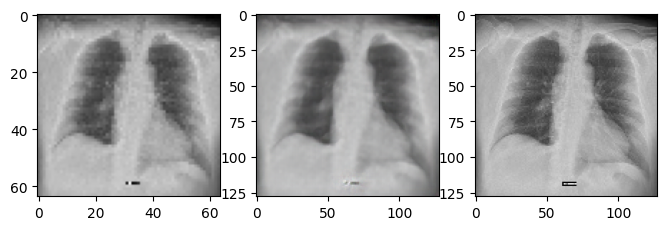

psnr between model output and ideal output = 25.178096771240234
ssim between model output and ideal output = 0.8241569705816566


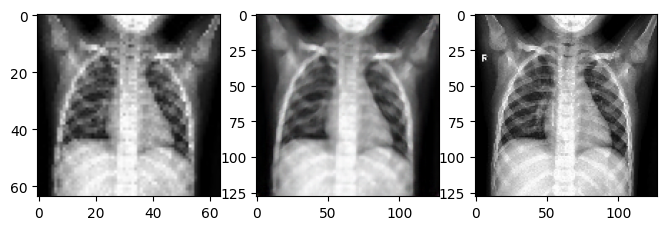

psnr between model output and ideal output = 24.95654296875
ssim between model output and ideal output = 0.8225852706924836


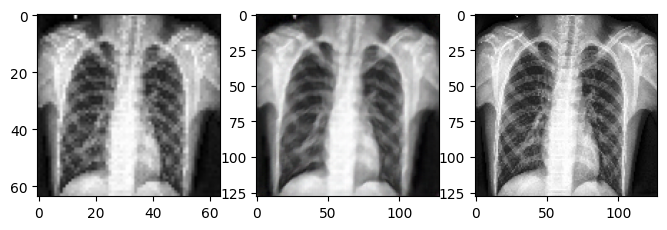

psnr between model output and ideal output = 28.0802059173584
ssim between model output and ideal output = 0.8964400832467314


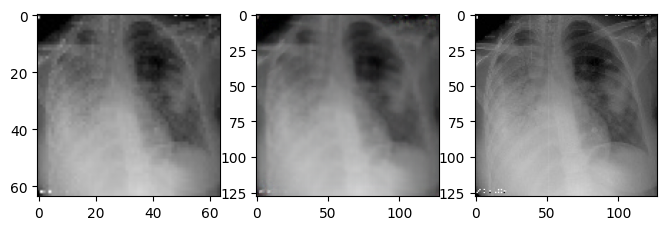

In [18]:
itr = 1
for img, label in medical_test_loader: # medical_test_loader
  if (itr==5):
    break
  img = img.to(device)
  label = label.to(device)
  with torch.no_grad():
    output = model(img)
  output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
  output = (output * 255.0).round().astype(np.uint8)
  plt.figure(figsize=(8, 8))
  plt.subplot(1,3,1)
  plt.imshow(img[0].cpu().permute(1, 2, 0))
  plt.subplot(1, 3, 2)
  plt.imshow(output.transpose(1, 2, 0))
  plt.subplot(1, 3, 3)
  plt.imshow(label[0].cpu().permute(1, 2, 0))
  print(f"psnr between model output and ideal output = {psnr_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)}")
  print(f"ssim between model output and ideal output = {ssim_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)}")

  plt.show()
  itr += 1
  # break

### Other resolution test data Results

/tmp/ipykernel_1584/1785861820.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


psnr between model output and ideal output = 15.677596092224121
ssim between model output and ideal output = 0.4331690127394438


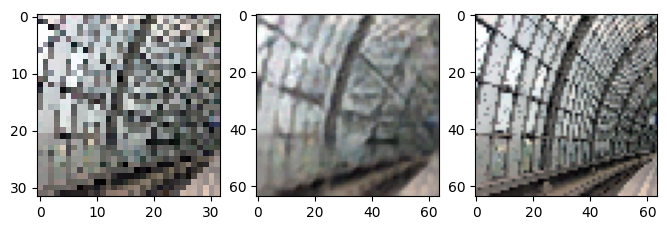

psnr between model output and ideal output = 11.525031089782715
ssim between model output and ideal output = 0.7025926609264682


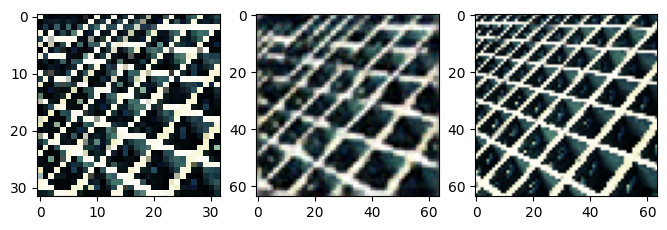

psnr between model output and ideal output = 16.96105194091797
ssim between model output and ideal output = 0.5769657330812957


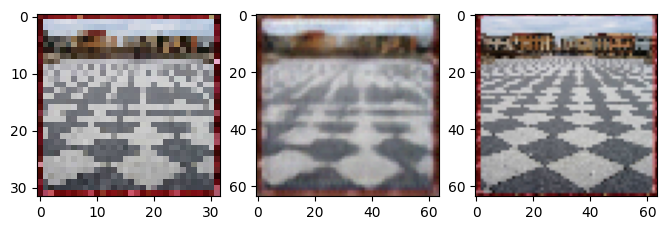

psnr between model output and ideal output = 21.79307746887207
ssim between model output and ideal output = 0.8463515393882851


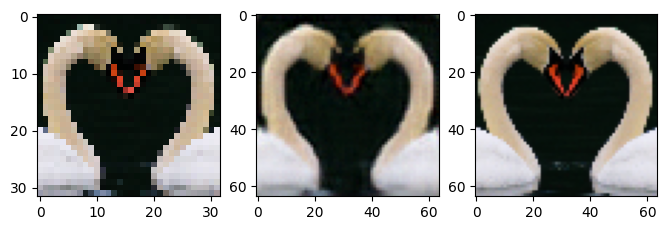

In [19]:
itr = 1
for img, label in test_32_loader:
  if (itr==5):
    break
  img = img.to(device)
  label = label.to(device)
  with torch.no_grad():
    output = rcan_model(img)
  output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
  output = (output * 255.0).round().astype(np.uint8)
  plt.figure(figsize=(8, 8))
  plt.subplot(1,3,1)
  plt.imshow(img[0].cpu().permute(1, 2, 0))
  plt.subplot(1, 3, 2)
  plt.imshow(output.transpose(1, 2, 0))
  plt.subplot(1, 3, 3)
  plt.imshow(label[0].cpu().permute(1, 2, 0))
  print(f"psnr between model output and ideal output = {psnr_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)}")
  print(f"ssim between model output and ideal output = {ssim_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)}")

  plt.show()
  itr += 1
  # break

# Interpolation Comparison

In [87]:
def bilinear_interpolation(image, scale):
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

def bicubic_interpolation(image, scale):
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return resized_image

def area_based_interpolation(image, scale):
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_image

def lanczos_interpolation(image, scale):
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
    return resized_image


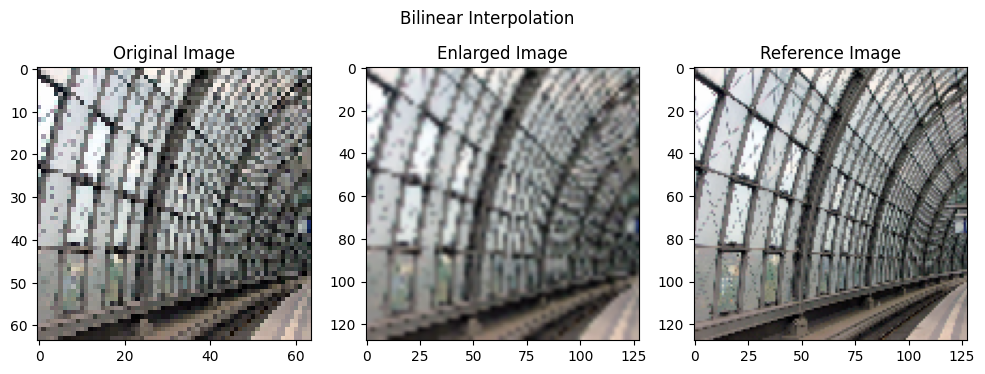

PSNR = 18.15605354309082
SSIM = 0.6037634466098927


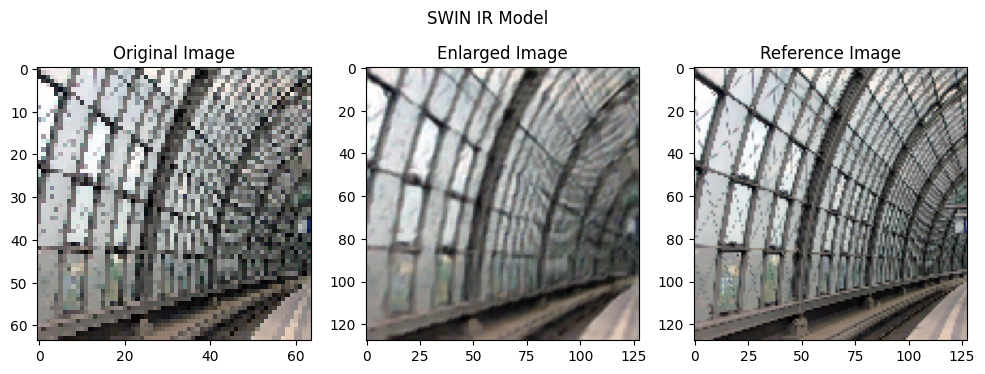

PSNR = 18.886451721191406
SSIM = 0.6592356659173528


In [21]:
# Load the image
image = cv2.imread('trainsets/dataset_final/dataset/64/images/1.bmp')
ref = cv2.imread("trainsets/dataset_final/dataset/128/images/1.bmp")

# Enlarge the image by a scale factor of 2
enlarged_image = bilinear_interpolation(image, 2)

image_t = image.transpose(2, 0, 1)/255.0
image_t = image_t[np.newaxis, :]
image_t = torch.tensor(image_t, dtype=torch.float32)
image_t = image_t.to(device)
with torch.no_grad():
    our_image = model(image_t)
our_image = our_image.data.squeeze().float().cpu().clamp_(0, 1).numpy()
our_image = (our_image * 255.0).round().astype(np.uint8)

# Display the original and enlarged images
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.title("Original Image")
plt.subplot(132)
plt.imshow(cv2.cvtColor(enlarged_image, cv2.COLOR_RGB2BGR))
plt.title("Enlarged Image")
plt.subplot(133)
plt.imshow(cv2.cvtColor(ref, cv2.COLOR_RGB2BGR))
plt.title("Reference Image")
plt.suptitle("Bilinear Interpolation")
plt.show()

print(f"PSNR = {psnr_func(ref/255, enlarged_image/255)}")
print(f"SSIM = {ssim_func(ref/255, enlarged_image/255)}")

# Display the original and enlarged images
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.title("Original Image")
plt.subplot(132)
plt.imshow(cv2.cvtColor(our_image.transpose(1, 2, 0), cv2.COLOR_RGB2BGR))
plt.title("Enlarged Image")
plt.subplot(133)
plt.imshow(cv2.cvtColor(ref, cv2.COLOR_RGB2BGR))
plt.title("Reference Image")
plt.suptitle("SWIN IR Model")
plt.show()

print(f"PSNR = {psnr_func(ref/255, our_image.transpose(1, 2, 0)/255)}")
print(f"SSIM = {ssim_func(ref/255, our_image.transpose(1, 2, 0)/255)}")

# Logs

In [93]:
import datetime
import os

def logData(lines, note):
    time = datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    if not os.path.exists("logs"):
        os.makedirs("logs")
        os.makedirs("logs/rcan_logs")
    fileName = f"logs/rcan_logs/64_100_0.001_0.75_10/{note}.csv"
    with open(fileName, "w") as f:
        for l in lines:
            line = ""
            for x in range(len(l)-1):
                line += f"{l[x]}, "
            line += f"{l[-1]}\n"
            f.write(line)
    
    print(f"Results logged to {fileName}")
    return


def testData(scale, epochs, batchSize, test_loader):
#     test_loader = makeTestLoader()
    itr = 1
    categories = ["imageN","model_psnr","bilinInter_psnr","bicubInter_psnr","areaInter_psnr","lanczosInter_psnr", "model_ssim","bilinInter_ssim","bicubInter_ssim","areaInter_ssim","lanczosInter_ssim"]
    lines = [[], categories]
    psnrArr = []
    ssimArr = []
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        
        with torch.no_grad():
            output = rcan_model(img)
        output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output = (output * 255.0).round().astype(np.uint8)
        
        psnr = psnr_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)
        ssim = ssim_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)
#         print(ssim)
        psnrArr.append(psnr)
        ssimArr.append(ssim)
#         print(img.shape)
        img = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        o1 = bilinear_interpolation(img, scale)
        o2 = bicubic_interpolation(img, scale)
        o3 = area_based_interpolation(img, scale)
        o4 = lanczos_interpolation(img, scale)
        
        psnr1 = psnr_func(label[0].cpu().permute(1, 2, 0), o1)
        psnr2 = psnr_func(label[0].cpu().permute(1, 2, 0), o2)
        psnr3 = psnr_func(label[0].cpu().permute(1, 2, 0), o3)
        psnr4 = psnr_func(label[0].cpu().permute(1, 2, 0), o4)
        
        ssim1 = ssim_func(label[0].cpu().permute(1, 2, 0), o1)
        ssim2 = ssim_func(label[0].cpu().permute(1, 2, 0), o2)
        ssim3 = ssim_func(label[0].cpu().permute(1, 2, 0), o3)
        ssim4 = ssim_func(label[0].cpu().permute(1, 2, 0), o4)
        
        metrics = [itr, psnr, psnr1, psnr2, psnr3, psnr4, ssim, ssim1, ssim2, ssim3, ssim4]
#         print(metrics)
        lines.append(metrics)
        
        itr += 1
    psnrArr = np.array(psnrArr)
    ssimArr = np.array(ssimArr)
    avgPSNR = np.mean(psnrArr)
    avgSSIM = np.mean(ssimArr)
    print(f"Average PSNR: {avgPSNR}")
    print(f"Average SSIM: {avgSSIM}")
    
    lines[0] = [datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"), f"scale={scale}", f"epochs={epochs}", f"batchSize={batchSize}", f"avgPSNR={avgPSNR}", f"avgSSIM={avgSSIM}"]
    
    return lines
   

In [95]:
# lines = testData(scale=scale, epochs=epochs, batchSize=batchSize, test_loader=test_loader)
# logData(lines, "_test64")

In [98]:
lines = testData(scale=scale, epochs=epochs, batchSize=batchSize, test_loader=landscape_test_loader)
logData(lines, "_land64")

/tmp/ipykernel_10587/1785861820.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


Average PSNR: 22.60427131652832
Average SSIM: 0.6478929394742097
Results logged to logs/rcan_logs/64_100_0.001_0.75_10/_land64.csv


In [77]:
new_train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
lines = testData(scale=scale, epochs=epochs, batchSize=batchSize, test_loader=new_train_loader)
logData(lines, "_train64")

/tmp/ipykernel_10587/1785861820.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_tensor = torch.tensor(img1, dtype=torch.float32)


Average PSNR: 20.59175373826708
Average SSIM: 0.6780882412388263
Results logged to logs/rcan_logs/64_500_0.001_0.75_10/log02-05-2024 17:36:06_train64.csv


# Occlusion Ascription Map

In [16]:
itr = 1
all_metrics = []
for img, label in test_loader:
    if itr == 10:
        break

    label = label.to(device)

    patch_size = 2
    height, width = img.shape[2], img.shape[3]

    patchIndices = []
    occludedImages = []
    
    # calculae average pixel value of the image
    avg_pixel_value = img.mean()

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            temp = img.clone().detach()
            temp[:, :, i:i+patch_size, j:j+patch_size] = avg_pixel_value # 0
            occludedImages.append(temp)

    metrics = []
    for new_img in occludedImages:
        new_img = new_img.to(device)
        with torch.no_grad():
            output = rcan_model(new_img)
        output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output = (output * 255.0).round().astype(np.uint8)
        # plt.subplot(121)
        # plt.imshow(new_img[0].cpu().permute(1, 2, 0))
        # plt.subplot(122)
        # plt.imshow(output.transpose(1, 2, 0)/255)
        # plt.show()
        ssim_val = ssim_func(label[0].cpu().permute(1, 2, 0), output.transpose(1, 2, 0)/255)
        metrics.append(ssim_val)
    all_metrics.append(metrics)

    itr += 1


In [26]:
# for a local patch

itr = 1
all_metrics = []
for img, label in test_loader:
    if itr == 2:
        break

    label = label.to(device)

    patch_size = 2
    height, width = img.shape[2], img.shape[3]

    patchIndices = []
    occludedImages = []
    
    # calculae average pixel value of the image
    avg_pixel_value = img.mean()

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            temp = img.clone().detach()
            temp[:, :, i:i+patch_size, j:j+patch_size] = avg_pixel_value # 0
            occludedImages.append(temp)

    metrics = []
    for new_img in occludedImages:
        new_img = new_img.to(device)
        with torch.no_grad():
            output = rcan_model(new_img)
        output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output = (output * 255.0).round().astype(np.uint8)
        # plt.subplot(121)
        # plt.imshow(new_img[0].cpu().permute(1, 2, 0))
        # plt.subplot(122)
        # plt.imshow(output.transpose(1, 2, 0)/255)
        # plt.show()
        center_x = output.transpose(1, 2, 0).shape[1] // 2
        center_y = output.transpose(1, 2, 0).shape[0] // 2

        # Calculate the coordinates of the top-left corner of the 4x4 image
        crop_left = center_x - 4
        crop_top = center_y - 4
        crop_right = crop_left + 8
        crop_bottom = crop_top + 8

        # Crop the 4x4 image
        cropped_output = output.transpose(1, 2, 0)/255
        cropped_output = cropped_output[crop_top:crop_bottom, crop_left:crop_right, :]
        cropped_label = label[0].cpu().permute(1, 2, 0)        
        cropped_label = cropped_label[crop_top:crop_bottom, crop_left:crop_right, :]
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(cropped_output)
        plt.subplot(1,2,2)
        plt.imshow(cropped_label)
        plt.show()
        
        # print(crop_top, crop_bottom, crop_left, crop_right)
        # print(cropped_label.shape, cropped_output.shape)
        ssim_val = ssim_func(cropped_label, cropped_output)
        metrics.append(ssim_val)
    all_metrics.append(metrics)

    itr += 1


In [49]:
import seaborn as sns

def plot_heatmap(arr):
    n = int(np.sqrt(len(arr)))
    matrix = np.array(arr).reshape(n, n)
    # print(matrix.shape)

    center_x = matrix.shape[1] // 2
    center_y = matrix.shape[0] // 2

    crop_left = center_x - 2
    crop_top = center_y - 2
    crop_right = crop_left + 4
    crop_bottom = crop_top + 4    
    matrix[crop_top:crop_bottom, crop_left:crop_right] = matrix[0,0]
    
    sns.heatmap(matrix, annot=False, fmt=".8f", cmap="coolwarm")
    
    # plt.imshow(matrix, cmap='hot', interpolation='nearest')
    # plt.colorbar()
    # plt.show()

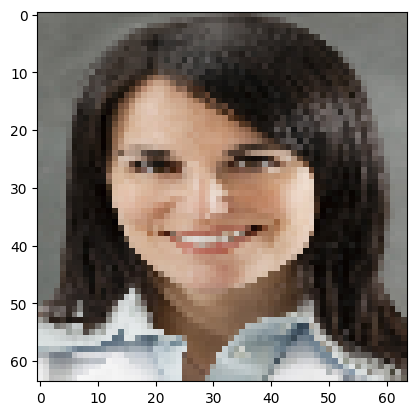

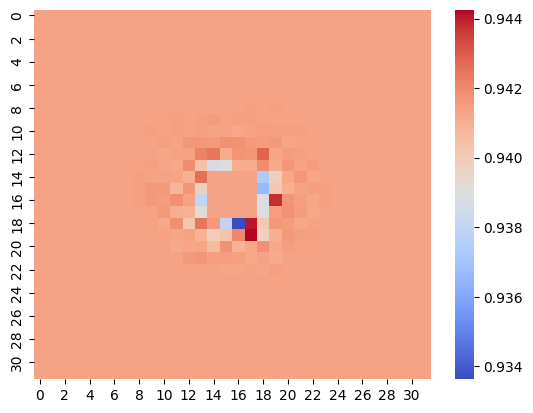

In [50]:
itr = 1
for img, label in test_loader:
    if itr == 2:
        break
        
    plt.imshow(img[0].cpu().permute(1, 2, 0))
    plt.show()
    plot_heatmap(all_metrics[itr-1])
        
    itr +=1

# Visualize Logs

In [112]:
# load logs/rcan_logs/log29-04-2024 22:50:04_test64.csv

import pandas as pd

# convert csv to dataframe from second row

df = pd.read_csv("logs/rcan_logs/64_100_0.001_0.75_10/_land64.csv", skiprows=1)
# print(df.columns)


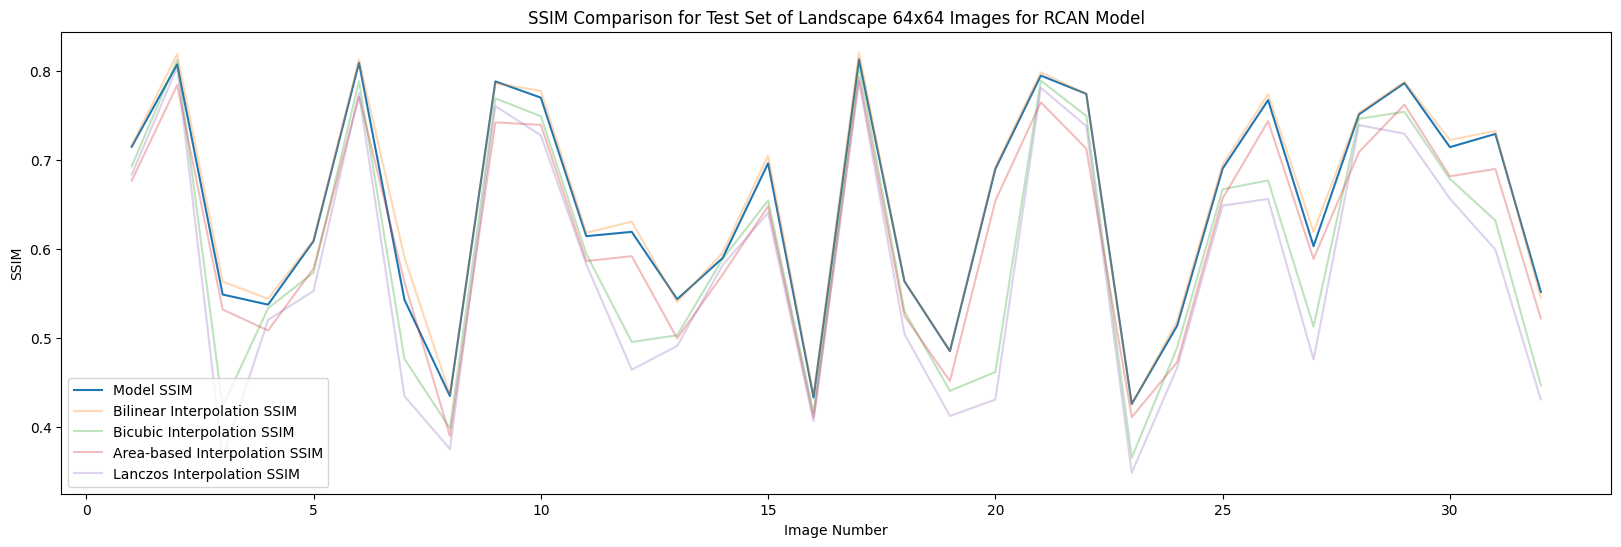

In [114]:
plt.figure(figsize=(20, 6))
plt.plot(df["imageN"][:32], df[" model_ssim"][:32], label="Model SSIM")
plt.plot(df["imageN"][:32], df[" bilinInter_ssim"][:32], label="Bilinear Interpolation SSIM", alpha=0.3)
plt.plot(df["imageN"][:32], df[" bicubInter_ssim"][:32], label="Bicubic Interpolation SSIM", alpha=0.3)
plt.plot(df["imageN"][:32], df[" areaInter_ssim"][:32], label="Area-based Interpolation SSIM", alpha=0.3)
plt.plot(df["imageN"][:32], df[" lanczosInter_ssim"][:32], label="Lanczos Interpolation SSIM", alpha=0.3)
plt.xlabel("Image Number")
plt.ylabel("SSIM")
plt.title("SSIM Comparison for Test Set of Landscape 64x64 Images for RCAN Model")
plt.legend()
plt.show()

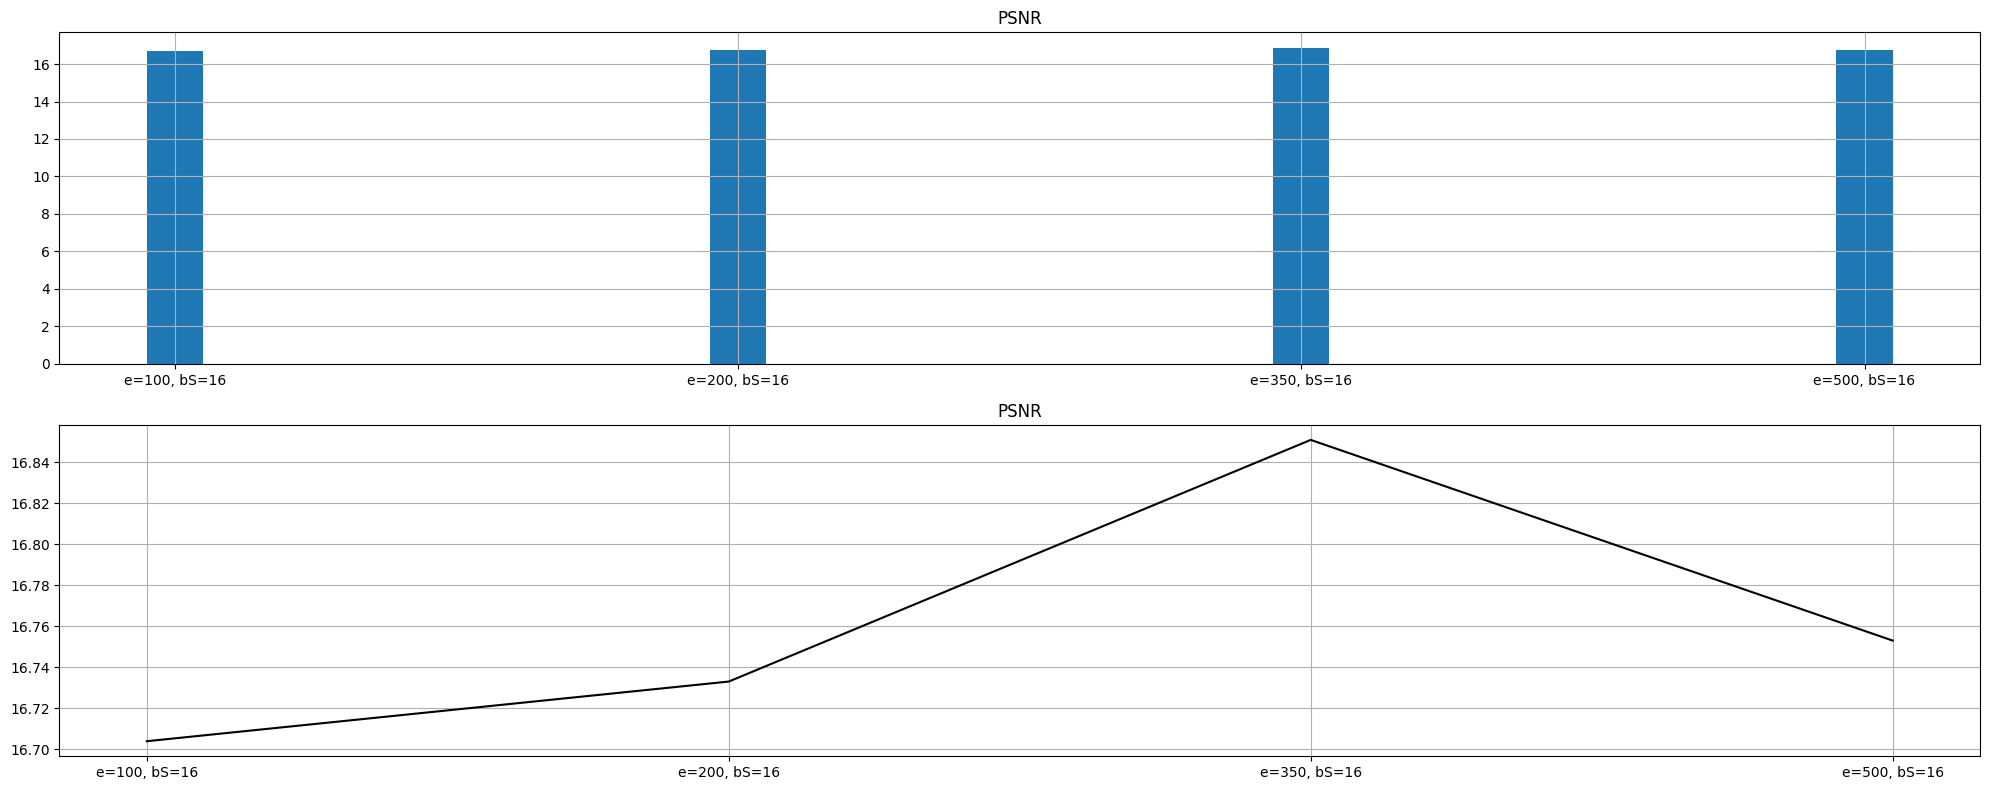

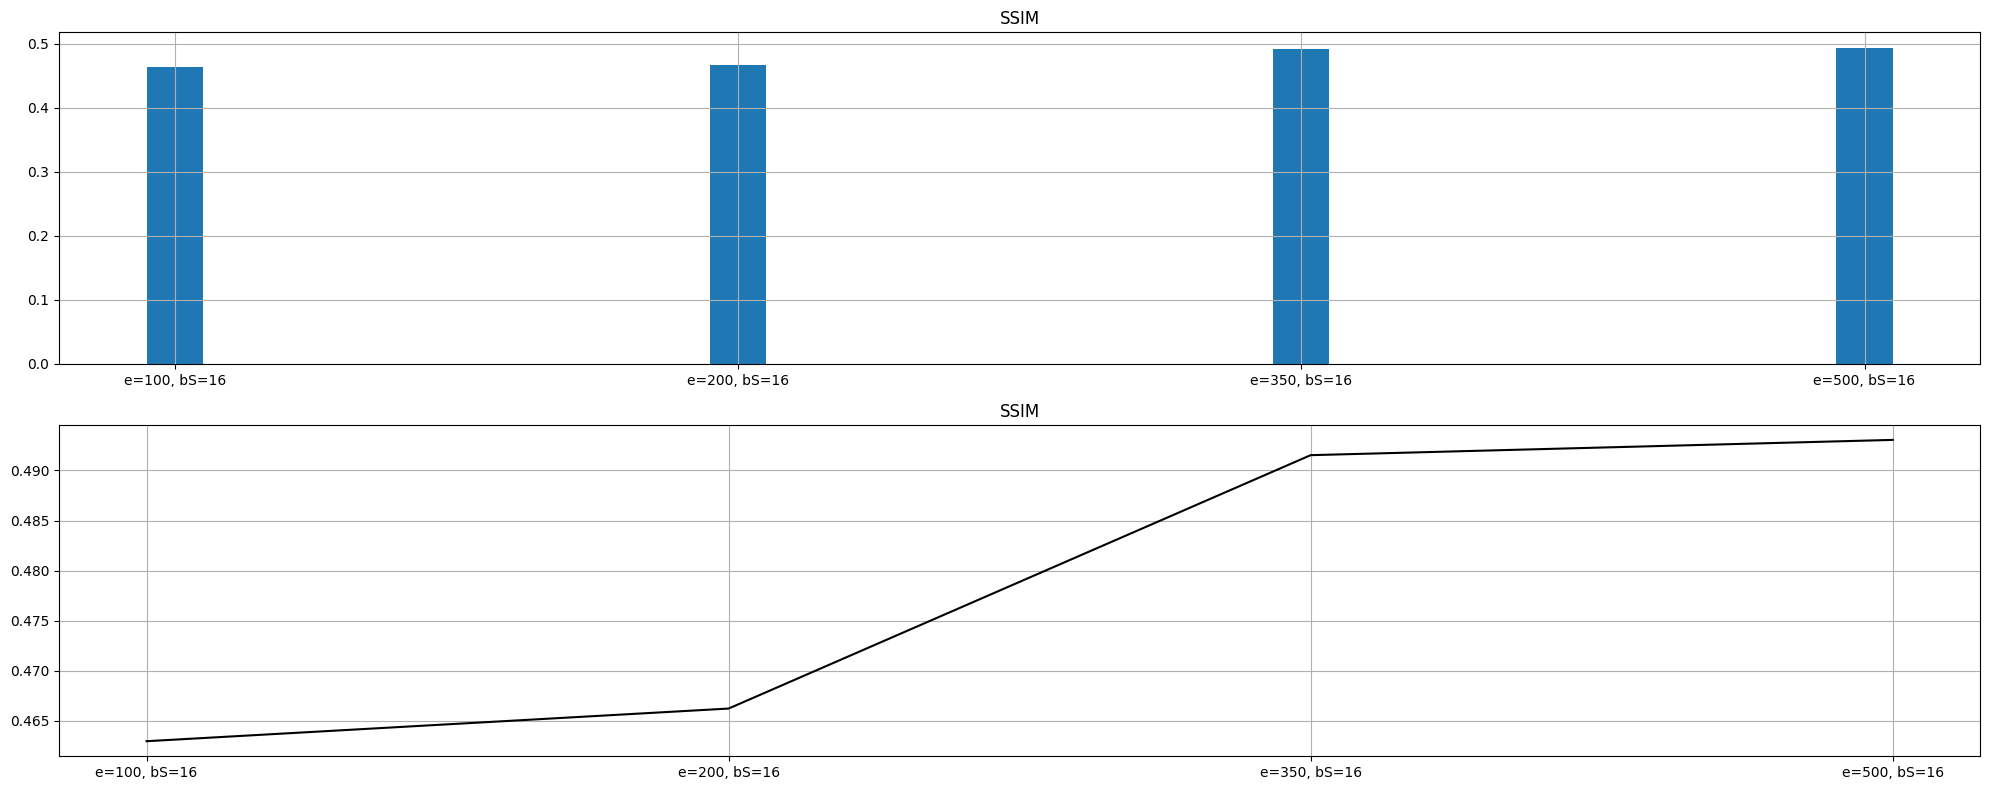

In [84]:
import matplotlib.pyplot as plt

def giveAxes(logPaths):
    xAxis = []
    psnrs = []
    ssims = []

    for i,path in enumerate(logPaths):
        df = pd.read_csv(path)
        info = df.iloc[0].index.values
        
        epochs = int(info[-4].split("=")[-1])
        batchSize = int(info[-3].split("=")[-1])
        
        psnr = float(info[-2].split("=")[-1])
        ssim = float(info[-1].split("=")[-1])
        
        xAxis.append(f"e={epochs}, bS={batchSize}")
        psnrs.append(psnr)
        ssims.append(ssim)
    
    return xAxis, psnrs, ssims

logPaths = ["logs/rcan_logs/32_100_0.001_0.75_10/_test32.csv","logs/rcan_logs/32_200_0.001_0.75_10/_test32.csv","logs/rcan_logs/32_350_0.001_0.75_10/_test32.csv", "logs/rcan_logs/32_500_0.001_0.75_10/_test32.csv"]
xAxis,psnrs,ssims = giveAxes(logPaths)

# Plotting
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.bar(xAxis,psnrs[::-1],width=0.1)
plt.title("PSNR")  
plt.grid()
plt.tight_layout()

plt.subplot(212)
plt.plot(xAxis,psnrs[::-1],color="black")
plt.title("PSNR")  
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.bar(xAxis,ssims[::-1],width=0.1)
plt.title("SSIM")  
plt.grid()
plt.tight_layout()

plt.subplot(212)
plt.plot(xAxis,ssims[::-1],color="black")
plt.title("SSIM")  
plt.grid()
plt.tight_layout()
plt.show()